In [1]:
import rasterio
import glob
import os
from rasterio.plot import show
from zipfile import ZipFile
import pandas as pd
import shutil
import numpy as np
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
shutil.rmtree(f"./data/inputs/", ignore_errors=True)
shutil.rmtree(f"./data/outputs/", ignore_errors=True)

In [3]:
DATA_DIR = "./data/files_list"
s1_au_df = pd.read_csv(os.path.join(DATA_DIR, "s1_au.csv"), names=["ID","Path"])
s1_an_df = pd.read_csv(os.path.join(DATA_DIR, "s1_an.csv"), names=["ID","Path"])
s2_au_df = pd.read_csv(os.path.join(DATA_DIR, "s2_au.csv"), names=["ID","Path"])
s2_an_df = pd.read_csv(os.path.join(DATA_DIR, "s2_an.csv"), names=["ID","Path"])

In [4]:
def find_polarisation_files_s1(dir:str) -> list[str]:
    """
    Finds Sentinel 1 data from the provided path.
    """
    return glob.glob(os.path.join(dir, "measurement", "*"))

In [5]:

def load_s1_scenes(
        zip_file_path:str, 
        zip_file_id:str, 
        subdir_name:str = "", 
        remove_input:bool = True,
    ) -> tuple:
    """
    Loads S1 scenes from provided path and id
        * `zip_file_path` and `zip_file_ids` are the path and id of the data.
        * `subdir_name` will be added to the output directory path if provided
    """

    with ZipFile(zip_file_path) as f:
        f.extractall(f"./data/inputs/{zip_file_id}/{subdir_name}")
    data_dir = os.listdir(f"./data/inputs/{zip_file_id}/{subdir_name}")[0]
    dir = os.path.join(f"./data/inputs/{zip_file_id}/{subdir_name}", data_dir)
    band_files = find_polarisation_files_s1(dir)
    scenes = [rasterio.open(band_file) for band_file in band_files]
    
    if remove_input:
        shutil.rmtree(f"./data/inputs/{zip_file_id}/{subdir_name}", ignore_errors=True)
    
    return scenes

In [6]:
def dwonsample_dataset(dataset_path:str, scale_factor:float):
    """
    Downsamples the output data and returns the new downsampled data and its new affine transformation according to `scale_factor`
    """
    with rasterio.open(dataset_path) as dataset:
        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * scale_factor),
                int(dataset.width * scale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
    return data, transform

In [7]:
def transform_s1_data(
        scenes, 
        scale_factor = 0.03, 
    ) -> tuple:
    """
    Downsamples a list of scenes and returns their new data and affine transformations.
    """
    new_data = []
    new_transforms = []
    for scene in scenes:
        new_datum, new_transform = dwonsample_dataset(scene.name, scale_factor)
        new_data.append(new_datum)
        new_transforms.append(new_transform)

    return new_data, new_transforms

def enhance_color(data, is_slc:bool = True):
    """
    Enhances the generated data for better visualisation
    """
    if is_slc:
        amplitude = np.sqrt(data.real ** 2 + data.imag ** 2)
        amplitude = 10 * np.log10(amplitude + 2.0e-10)
    else:
        amplitude = data / 256
    amplitude = amplitude.astype("float64")
    amplitude *= 255 / amplitude.max()
    return amplitude.astype("uint8")


##### Sentinel 1 Australia GRD

In [8]:
num_file = 10
zip_file_id = s1_au_df.ID[num_file]
zip_file_path = s1_au_df.Path[num_file]
subdir_name = f"sub{num_file}"
scenes = load_s1_scenes(
    zip_file_path, 
    zip_file_id, 
    subdir_name, 
    remove_input=False
)
new_data, new_transforms = transform_s1_data(
    scenes, 
    scale_factor=0.03
)

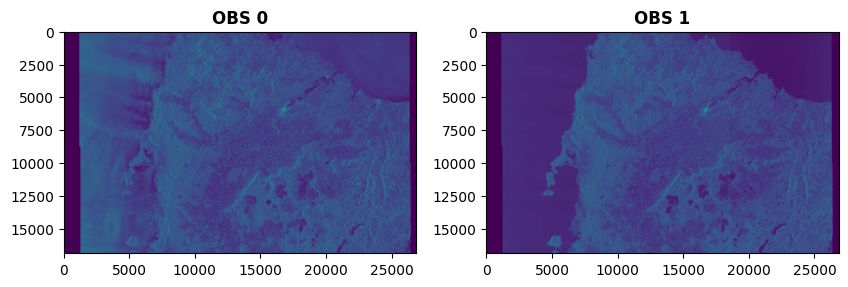

In [9]:
fig, axes = plt.subplots(1, len(new_data), figsize=(5 * len(new_data), 10 * len(new_data)))
if type(axes) != np.ndarray:
    axes = [axes]
for i, d in enumerate(new_data):
    show(enhance_color(d, False), ax=axes[i], title=f"OBS {i}", transform=new_transforms[i])

##### Sentinel 2 Australia SLC

In [10]:
num_file = 16
zip_file_id = s1_au_df.ID[num_file]
zip_file_path = s1_au_df.Path[num_file]
subdir_name = f"sub{num_file}"
scenes = load_s1_scenes(
    zip_file_path, 
    zip_file_id, 
    subdir_name, 
    remove_input=False
)
new_data, new_transforms = transform_s1_data(
    scenes, 
    scale_factor=0.03
)

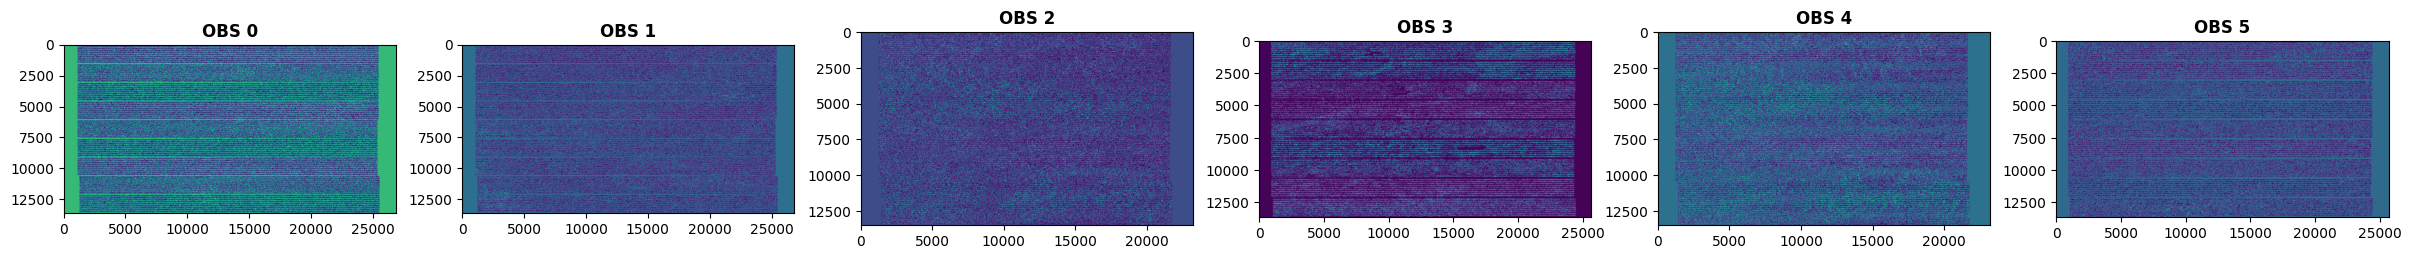

In [11]:
fig, axes = plt.subplots(1, len(new_data), figsize=(5 * len(new_data), 10 * len(new_data)))
if type(axes) != np.ndarray:
    axes = [axes]
for i, d in enumerate(new_data):
    show(enhance_color(d), ax=axes[i], title=f"OBS {i}", transform=new_transforms[i])

##### Sentinel 2 Antarctica GRD

In [12]:
num_file = 7
zip_file_id = s1_an_df.ID[num_file]
zip_file_path = s1_an_df.Path[num_file]
subdir_name = f"sub{num_file}"
scenes = load_s1_scenes(
    zip_file_path, 
    zip_file_id, 
    subdir_name, 
    remove_input=False
)
new_data, new_transforms = transform_s1_data(
    scenes, 
    scale_factor=0.03
)

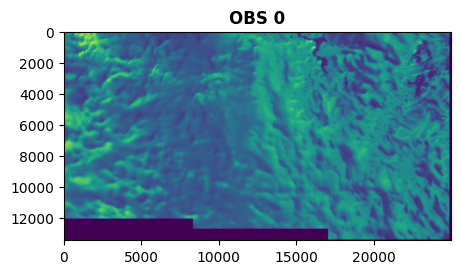

In [13]:
fig, axes = plt.subplots(1, len(new_data), figsize=(5 * len(new_data), 10 * len(new_data)))
if type(axes) != np.ndarray:
    axes = [axes]
for i, d in enumerate(new_data):
    show(enhance_color(d, False), ax=axes[i], title=f"OBS {i}", transform=new_transforms[i])

##### Sentinel 2 Antarctica SLC

In [14]:
num_file = 8
zip_file_id = s1_an_df.ID[num_file]
zip_file_path = s1_an_df.Path[num_file]
subdir_name = f"sub{num_file}"
scenes = load_s1_scenes(
    zip_file_path, 
    zip_file_id, 
    subdir_name, 
    remove_input=False
)
new_data, new_transforms = transform_s1_data(
    scenes, 
    scale_factor=0.03
)

3


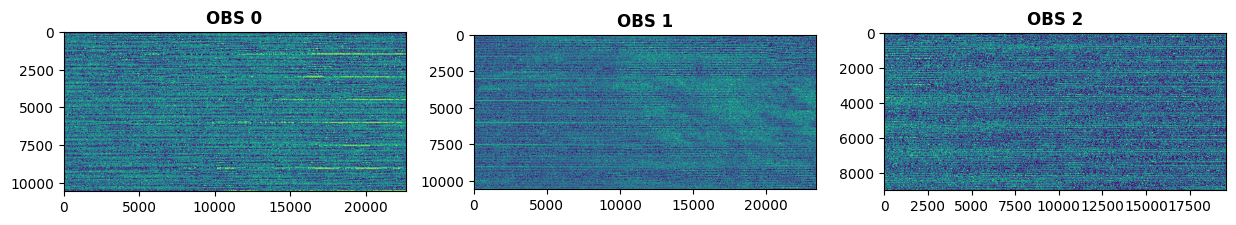

In [15]:
fig, axes = plt.subplots(1, len(new_data), figsize=(5 * len(new_data), 10 * len(new_data)))
if type(axes) != np.ndarray:
    axes = [axes]
print(len(axes))
for i, d in enumerate(new_data):
    show(enhance_color(d), ax=axes[i], title=f"OBS {i}", transform=new_transforms[i])